In [1]:
# multidimensional arrays
import numpy as np
import math as m
pi = 4*m.atan(1.)
# inline plots
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

<img src="attachment:image.png" width="250"> 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

<img src="attachment:image.png" width="250"> 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [3]:
def create_initial_config(N=None):
    """
    Create the starting initial configuration.
    
    All elements are {-1, 1} with 50% prob.
    The lattice is a square of size N.
    
    Parameters
    ----------
    N : int
        The system size.

    Returns
    -------
    config : np.array, (N, N)
        A random {-1, 1} array of size (N, N).
    """
    config = np.random.randint(2,size=(N,N))
    for i in range(N):
        for j in range(N):
            if ( not config[i][j]):
                config[i][j] = -1
    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [4]:
config = create_initial_config(N=100)
print(config,"\n",range(-1,1)[0],range(-1,2)[1],range(-1,2)[2])

[[ 1 -1 -1 ... -1  1  1]
 [ 1  1 -1 ...  1 -1  1]
 [-1 -1  1 ...  1 -1  1]
 ...
 [-1  1 -1 ... -1 -1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1 -1 -1 ... -1 -1 -1]] 
 -1 0 1


To plot our system we can use `plt.imshow()`, as follows:

-1
0
1


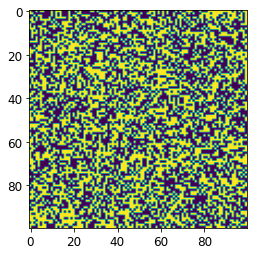

In [5]:
plt.imshow(config);
frec=range(-1,2)
for i in frec:
    print(i)

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

$\Delta E$ = $E(S(i,j) \rightarrow \; -S(i,j)) - E(S(i,j)) = 2J \sum_{(kl) = nn((i,j))} S(i,j)S(k,l) + 2 H S_k$

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [6]:
def metropolis_single_update(config=None, T=None):
    '''
    Do a single Monte Carlo update using Metropolis algorithm.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''
    # make sure config is square
    N, M = config.shape
    assert N == M
    
    # choose random site
    i = np.random.randint(N)
    j = np.random.randint(M)
    s =  config[i][j]
    
    # compute energy cost of flip
    # DeltaE is the possible energy cost, lo facciamo partire a 0
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 0
    frec=range(-1,2)
    for dx in frec:
        for dy in frec:
            #evitiamo di prendere la cella stessa, o di andare in diagonale
            if ((dx == 0) ^ (dy == 0)):
                #ora si può computare
                DeltaE += s*config[(i+dx)%N][(j+dy)%N]
    #ma non è tutto, dobbiamo cucinare DeltaE (con J=1 e H=0 c'è poco da cucinare)
    DeltaE *= 2
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE <= 0:
        # flip the spin
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        rando=np.random.uniform()
        # flip the spin with certain probability
        if (rando <= m.exp(-DeltaE/T)):
            # flip the sping
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i][j] = s
    
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

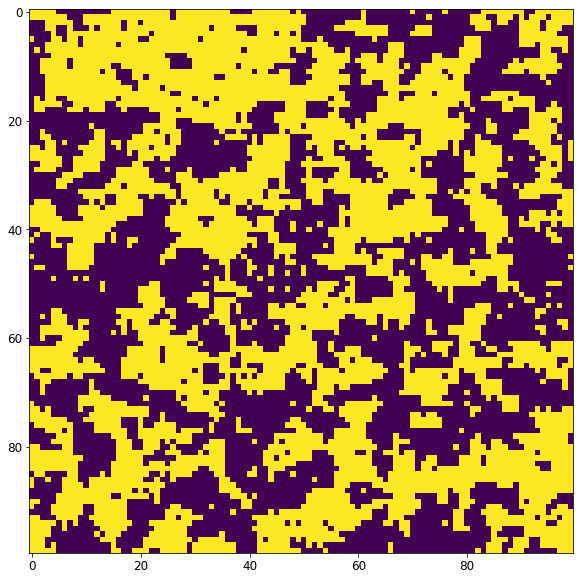

In [7]:
T_c = 2/np.log(1+np.sqrt(2))

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(12,10))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)
for t in range(10**5):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [8]:
def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [
        (i,j,i,(j+1)%N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        (i,j,(i+1)%N,j)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1][j1] * config[i2][j2]
    
    return E

In [9]:
confix= create_initial_config(N=20)
print(confix)
print(get_energy(confix))

[[ 1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1  1 -1]
 [-1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1]
 [-1  1 -1 -1 -1  1  1 -1  1 -1  1  1 -1  1 -1  1  1 -1  1  1]
 [ 1  1  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1  1 -1  1]
 [ 1 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1  1 -1  1]
 [-1 -1 -1 -1 -1  1 -1  1 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1]
 [-1 -1  1  1 -1 -1  1  1  1  1  1  1 -1  1 -1  1  1 -1 -1  1]
 [ 1  1 -1  1 -1  1  1  1  1 -1  1  1  1 -1  1 -1  1 -1 -1 -1]
 [ 1 -1 -1  1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1]
 [-1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1  1  1  1 -1]
 [ 1  1  1  1 -1  1 -1  1  1  1  1 -1  1 -1  1  1 -1  1 -1 -1]
 [ 1  1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1  1]
 [ 1  1  1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1  1 -1 -1  1]
 [-1  1 -1 -1  1  1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1]
 [ 1  1 -1 -1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1 -1 -1  1]
 [-1 -1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1 -1 -1 -1

In [10]:
def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    #creo la configurazione a caso
    config=create_initial_config(N)
    #creo il vettore che contiene le energie
    Es=np.zeros(n_updates)
    #meglio far calcolare solo una volta tutte le coppie
    Es[0]=get_energy(config)
    #faccio n_updates giri di metropolis
    for i in range(1,n_updates):
        De=metropolis_single_update(config,T)
        Es[i] = Es[i-1] + De
    return Es

### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [11]:
energy_evolution = get_energy_evolution(N=20,T=10,n_updates=300000)

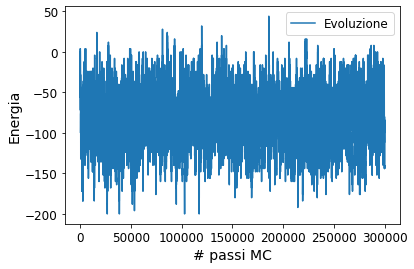

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(
            energy_evolution, label="Evoluzione")
ax.set_xlabel("# passi MC")
ax.set_ylabel("Energia")
ax.legend(loc="upper right")

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

With $T<T_c$ can distinguish the following two phases of evolution:
 <ol>
  <li>Initially the system is chaotic, therefore there are many possible moves
    that can decrease total energy at any step and energy eventually trends down;</li>
      <li>After a long time, a configuration of minimum energy is reached, from which any move
    is likely to increase the energy of the system and therefore evolution procedes with oscillation around the equilibrium point</li>
</ol> 
With $T=T_c$ the system does initially loses energy but after some initial arranging, its energy oscillates widely.
With $T>T_c$ the system does not organizes itself and energy has no anchoring point

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [13]:
import sys
sys.path.append("../code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [14]:
# create an instance of IsingModel
ising = IsingModel(N=100)

In [15]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

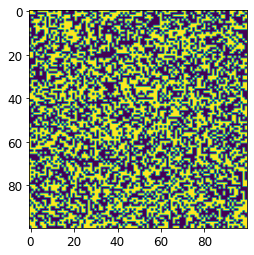

In [16]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [17]:
ising.SweepMetropolis(nTimes=100)

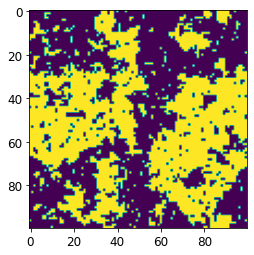

In [18]:
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [19]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2.269185314213022
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

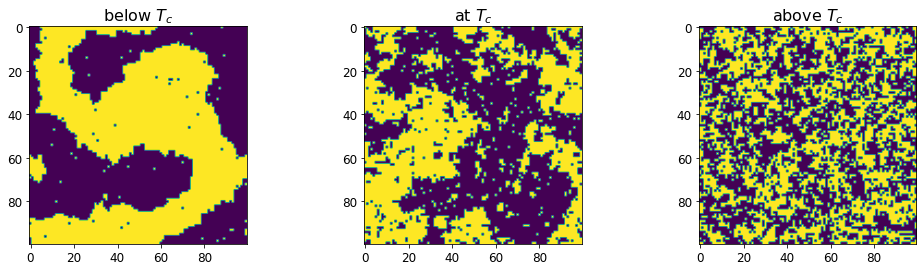

In [20]:
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

In [21]:
%%timeit
# your Ising implementation running for some number of updates
energy_evolution = get_energy_evolution(N=100,T=T_c,n_updates=10**5)

1.66 s ± 72.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
# Sethan's implementation running for some **equivalent** number of updates
ising.SweepMetropolis(nTimes=10)

416 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sethna's SweepMetropolis seems to generally be 4~5 times faster than ours with $N=100$

## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

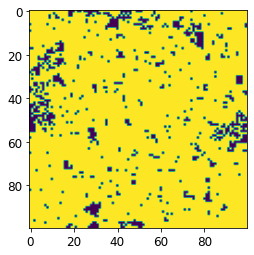

In [23]:
# set system size, temperature
ising_prova = IsingModel(N=100, T=2, H=H)
# run some Wolff sweeps, check if equilibrium
ising_prova.SweepWolff(nTimes=6)
plt.imshow(ising_prova.lattice)

The number of Wolff sweeps required for the system to reach equilibrium increases when $T$ gets closer to $T_c$ and is generally in the range [2 ~ 5]

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [24]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    modello = IsingModel(N=system_size, T=temperature, H=0) 
    # equilibrate
    modello.SweepWolff(nTimes=equilibration_time)
    # compute magnetization
    m=0
    for riga in modello.lattice:
        for spin in riga:
            m += (spin*2) - 1
    
    return m


### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [25]:
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=20)
# system size
system_size = 64
# equilibration time
equilibration_time = 7

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = calculate_magnetization(system_size,temperature,equilibration_time)
    magnetizations.append(abs(magnetization))
print(magnetizations)

[4012, 4014, 3944, 3908, 3866, 3664, 3312, 2998, 730, 470, 66, 292, 350, 48, 66, 358, 80, 126, 4, 130]


Text(0, 0.5, 'M')

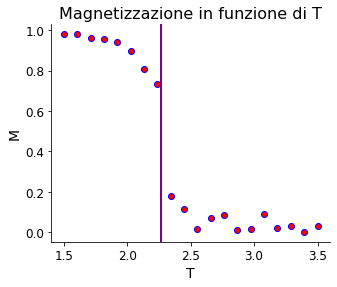

In [26]:
# define critical temperature
T_c = 2/np.log(1+np.sqrt(2))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
magnetizations =[magnetization/ system_size**2 for magnetization in magnetizations]
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures,
    magnetizations,
    # style keywords
    edgecolors="blue", color="red"#, s=...
)
ax.axvline(
    T_c,
    # style keywords
    c="purple", lw=2#, ls=...
)
ax.set_title("Magnetizzazione in funzione di T")
ax.set_xlabel("T")
ax.set_ylabel("M")

## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

$\chi =\frac{1}{T} (<M^2>-<M>^2)$

### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [27]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    config = ising.lattice*2-1
    N = len(config)
    
    edges = ...
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= ...
    return E / N**2

#basta usare get_energy(ising.lattice*2 - 1)/N**2

### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [28]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    # initiate model
    modello = IsingModel(system_size, temperature, 0) 
    # equilibrate
    modello.SweepWolff(nTimes=equilibration_time)
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for _ in range(n_samples):
        # change from 0,1 to -1,1 notation
        config=((modello.lattice)*2) - 1
        # get magnetization
        m=0
        for riga in config: 
            for spin in riga:
                m += spin
        m = float(m)/float((system_size**2))
        ms.append(m)
        m2s.append(m**2)
        # get energy
        e=float(get_energy(config))/float(system_size**2)
        es.append(e)
        e2s.append(e**2)
        # update system
        modello.SweepWolff(nTimes=1)
    # compute susceptibility and specific heat
    esm=0
    e2sm=0
    msm=0
    m2sm=0
    for i in range(n_samples):
            esm += es[i]
            e2sm += e2s[i]
            msm += ms[i]
            m2sm += m2s[i]
    esm /= n_samples
    e2sm /= n_samples
    msm /= n_samples
    m2sm/= n_samples
    susceptibility = (1/float(temperature))* float(m2sm - msm**2)
    specific_heat = (1/float(temperature**2))*float(e2sm - esm**2)
    
    return susceptibility, specific_heat



### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [29]:
%%time
#define range of temperatures: 50 points from 1.5 to 4.
temperatures = np.linspace(1.5,4,num=20)
# system size
system_size = 50
# equilibration time
equilibration_time = 10
# n_samples
n_samples = 15
(suscc, calspp)=([],[])

for T in temperatures:
    (susc,calsp)=calculate_susceptibility_specific_heat(system_size,  T, equilibration_time, 50)
    suscc.append(susc)
    calspp.append(calsp)

CPU times: user 19.8 s, sys: 3.41 ms, total: 19.8 s
Wall time: 19.8 s


Text(0.5, 1.0, 'Cal. spec. in funzione di T')

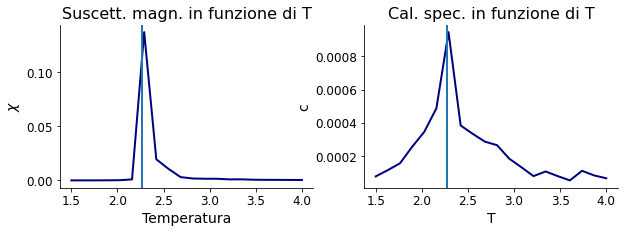

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax=ax1
ax.plot(temperatures,
       suscc,
       lw=2,
       c="navy",)
ax.axvline(T_c,
          lw=2)
ax.set_ylabel("$\chi$")
ax.set_xlabel("Temperatura")
ax.set_title("Suscett. magn. in funzione di T")

ax=ax2
ax.plot(temperatures,
       calspp,
       lw=2,
       c="navy")
ax.axvline(T_c,
          lw=2)
ax.set_ylabel("c")
ax.set_xlabel("T")
ax.set_title("Cal. spec. in funzione di T")


### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

The form of the functions $C(T)$ and $\chi (T)$, peaked on $T_c$ suggests there actually is a phase transition at $T_c$

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

<img src="attachment:image.png" width="600">

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

Here's my try:
1. We divide each row in continuous sections of the same spin;
2. We divide each column the same way;
3. We now have two lists of lists of points;
4. For every row-cluster we see if any col-cluster has any point in common: if so, we define a new cluster which is the union of the two and we remove the col-cluster from the list;
5. We now have a list of lists of points;
6. If any two lists have a point in common, we join them and do so until no lists have any point in common.

### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

<img src="attachment:image.png" width="600">

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [42]:
def get_labels(config):
    """
    Get unique cluster labels.
    
    Parameters
    ----------
    config : np.array, (N, N)
        Configuration of the system in {-1, 1} notation
    Returns
    -------
    labels : np.array, (N, N)
        Labels that identify the clusters
    """
    N=len(config)
    #print(N)
    rc=[]
    cc=[]
    #1 passo: trovare i row-cluster
    for i in range(N):
        s=config[i][0]
        cluster_temp=[]
        ultimo=False
        for j in range(N+1):
            if (config[i][j%N] == s):
                cluster_temp.append([i,j%N])
            else:
                rc.append(cluster_temp)
                cluster_temp=[[i,j%N]]
                s *= -1
                ultimo=True
            #fine della corsa
            if((j==N)): #and not ultimo):
                rc.append(cluster_temp)
    #2passo: trovare i colcluster
    for i in range(N):
        s=config[0][i]
        cluster_temp=[]
        ultimo=False
        for j in range(N+1):
            if (config[j%N][i] == s ):
                cluster_temp.append([j%N,i])
            else:
                cc.append(cluster_temp)
                cluster_temp=[[j%N,i]]
                s *= -1
                ultimo=True
            #fine della corsa
            if((j==N)):# and not ultimo):
                cc.append(cluster_temp)

    #print(rc)
    #print("Ecco i colclu")
    #print(cc)
    clusters=[]
    #attacchiamo tutti quelli con un punto in comune
    for rcluster in rc:
        cluster_temp=rcluster
        for ccluster in cc:
    #        print(ccluster)
            for punto1 in rcluster:
                for punto2 in ccluster:
                    if (np.array_equal(punto1,punto2)):
     #                   print("uguali")
                        cluster_temp=np.concatenate((cluster_temp,ccluster))
                        if (ccluster in cc):
                            k=cc.index(ccluster)
                            cc.pop(k)
        clusters.append(cluster_temp)
    #print(clusters)
    #print("label1")
    #adesso abbiamo dei minimega cluster che si estendono su righe,colonne!
    for cluster in clusters:
        for punto1 in cluster:
            for punto2 in cluster:
                k=np.argwhere(cluster==punto2)
                if (np.array_equal(punto1,punto2)):
                    np.delete(cluster,k)


#ora che abbiamo i  mini mega, basterà ricombinarli una volta, magari 2
    #for _ in (range(m.ceil(m.log2(float(len(config))))+1)):
    for _ in range(4):
        clusters2=[] 
        assorbiti=[]
        for i in range(len(clusters)):
            assorb=False
            partito=True
            for z in assorbiti:
                if(i==z):
                    assorb=True
                    partito=False
            if (not assorb):
                cluster_temp=clusters[i]
                for j in range(i+1,len(clusters)):
                    assorb=False
                    for a in assorbiti:
                        if (a==j):
                            assorb=True
                    if(not assorb):
                        for casella1 in cluster_temp:
                            if (not assorb):
                                for casella2 in clusters[j]:
                                    if np.array_equal(casella1,casella2):
                                        assorb=True
                                        assorbiti.append(j)
                                        cluster_temp = np.concatenate((cluster_temp,clusters[j]))
            if partito:
                clusters2.append(cluster_temp)
    #    print("Ecco i clusters2")
    #    print(clusters2)
        clusters=clusters2
    #eliminare gli uguali
    for i in range(len(clusters)):
        uguali=[]
        for j in range(len(clusters[i])):
            ugualb=False
            for l in uguali:
                if (l == j):
                    ugualb=True
            if not ugualb:
                for k in range(j+1,len(clusters[i])):
                    if (np.array_equal(clusters[i][j],clusters[i][k])):
                        uguali.append(k)
     #   print(uguali) 
        clusters[i]=np.delete(clusters[i],[uguali],0)
    #print(clusters)
    labels=config
    label=0
    for cluster in clusters:
        for cella in cluster:
            labels[cella[0]][cella[1]]=label
        label +=1
    ncluster= len(clusters)
    #clustersizes=np.zeros()
    return labels

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [35]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])
get_labels(config_test_0)

array([[0, 0, 0],
       [1, 1, 0],
       [1, 1, 0]])

In [36]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])
get_labels(config_test_1)

array([[0, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 2, 1, 1, 1, 0],
       [1, 2, 1, 0, 0, 0],
       [1, 2, 1, 1, 0, 1],
       [1, 1, 1, 0, 0, 0]])

In [37]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])
get_labels(config_test_2)

array([[ 0,  1,  2,  2,  1,  0,  3,  0,  0,  0],
       [ 1,  1,  1,  2,  2,  3,  3,  3,  0,  1],
       [ 4,  1,  5,  3,  3,  3,  6,  6,  7,  4],
       [ 4,  1,  5,  5,  5,  3,  6,  8,  0,  9],
       [ 1,  1,  5,  5, 10, 11, 12,  0,  0,  0],
       [ 0,  1,  1,  1, 13, 14,  0,  0, 15,  0],
       [ 1, 16,  1, 13, 13, 14, 14, 14,  0,  0],
       [ 1,  1,  1,  1, 13, 13, 14, 14, 14,  0],
       [ 0,  0,  1,  1, 13, 17,  0,  0,  0,  0],
       [ 0,  0,  1,  1,  1,  0,  0,  0,  0, 18]])

Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

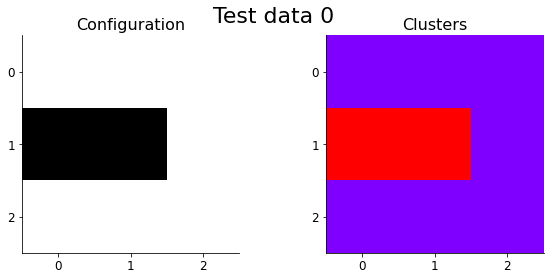

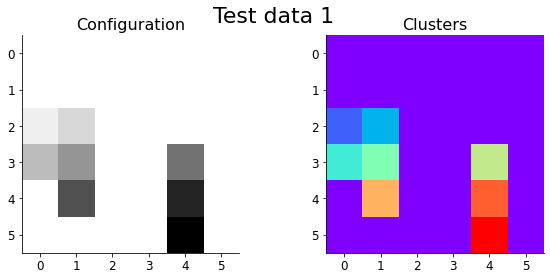

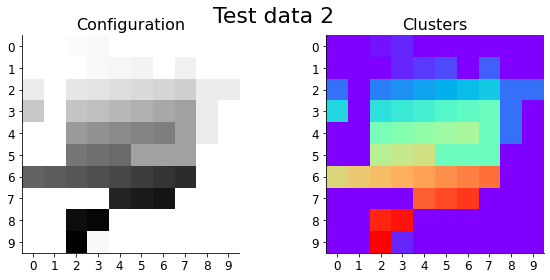

In [38]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

In [47]:
%%time
    modello = IsingModel(30, 2, H=0) 
    # equilibrate
    modello.SweepWolff(nTimes=10)
    config=((modello.lattice)*2)-1
labels = get_labels(config)
print(labels)

[[ 0  0  0  0  0  0  0  0  1  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  3  0  0  0]
 [ 0  0  4  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  7  0
   0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  7
   0  0  0  0  0  8]
 [ 0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10 10  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

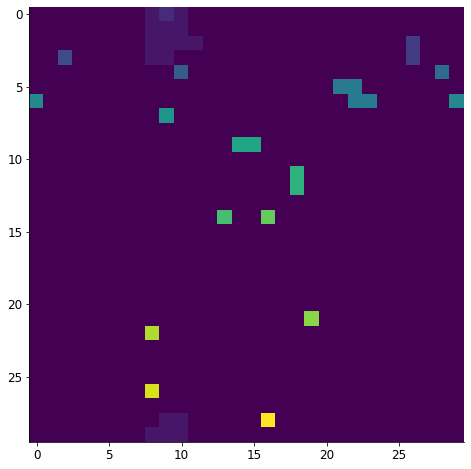

In [48]:
plt.figure(figsize=(10, 8))
plt.imshow(labels)

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [69]:
import collections as col
def get_sizes(labels):
    N= len(labels)
    labels= np.reshape(labels,N**2)
    sizes=[]
    coun= col.Counter(labels)
    c=0
    while(coun[c]):
        sizes.append(coun[c])
        c+=1
    return sizes
print(get_sizes(labels))

[861, 16, 1, 2, 1, 1, 1, 4, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1]


### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

I'd expect to find very little clusters trending towards the size of a single cell


### Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

*Your answer here*

In [88]:
modello=IsingModel(20,15,0)
modello.SweepWolff(nTimes=10)
config = (modello.lattice*2)-1
labels = get_labels(config)
sizes = get_sizes(labels)

[26, 38, 50, 2, 1, 3, 4, 7, 1, 1, 26, 1, 13, 1, 46, 5, 1, 1, 32, 2, 1, 1, 2, 3, 1, 3, 57, 1, 20, 5, 11, 6, 1, 7, 2, 2, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1]


(1, 57)

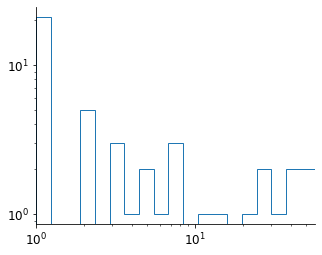

In [89]:
# use logarithmic bins and logarithmic axes!
print(sizes)
bins = np.geomspace(min(sizes), max(sizes), num=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizes, bins=bins, histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizes), max(sizes))

### Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

In [90]:
# do simulation
modelloC=IsingModel(20,T_c,0)
modelloC.SweepWolff(nTimes=10)
configC = (modelloC.lattice*2)-1
labelsC = get_labels(configC)
sizesC = get_sizes(labelsC)

[305, 3, 2, 1, 1, 1, 1, 2, 67, 2, 1, 1, 1, 9, 2, 1]


(1, 305)

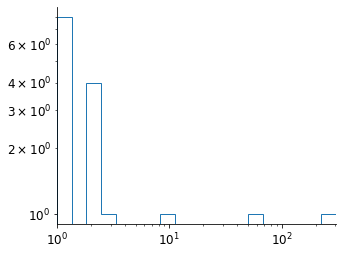

In [91]:
# plot results
print(sizesC)
bins = np.geomspace(min(sizesC), max(sizesC), num=20)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(sizesC, bins=bins, histtype="step")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min(sizesC), max(sizesC))